# Markov chains for gradient estimation in the context of Restricted Boltzman Machine Learning

_Authors: Alan García and Sandra Burgos_

Throughout this notebook, the implementation of two training methods for Restricted Boltzmann Machines (RBMs) is carried out: the Contrastive Divergence algorithm and Persistent Contrastive Divergence. These implementations require a deep understanding of how RBMs function, and not all aspects of the implementation are explicitly explained within the notebook. More details on the implementation can be found in the attached report.

Additionally, despite having created functional implementations, several challenges were encountered during development and it is possible that there are still bugs that have not been identified.

## Packages

In [1]:
# Main packages for the implementation
import gzip
import numpy as np
from abc import ABC, abstractmethod
import pickle
import os

# Just for working with datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches

# For plotting
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42) # For reproducibility

## Datasets

For the development and testing of the RBM implementations, the MNIST handwritten digits dataset has been used. The training and test sets were downloaded from the official website [https://yann.lecun.com/exdb/mnist/](https://yann.lecun.com/exdb/mnist/), where the necessary information for decoding the dataset is also provided.

The `MNIST` class implements an iterator that reads each image and its associated label from the dataset. Additionally, two methods, `to_list()` and `to_numpy()`, have been implemented to facilitate the conversion of the dataset into formats that are more convenient for processing and model training.

In [ ]:
class MNIST:
    """
    https://yann.lecun.com/exdb/mnist/
    ubyte format of MNIST images:
        [offset] [type]          [value]          [description]
        0000     32 bit integer  0x00000803(2051) magic number
        0004     32 bit integer  10000            number of images
        0008     32 bit integer  28               number of rows
        0012     32 bit integer  28               number of columns
        0016     unsigned byte   ??               pixel
        0017     unsigned byte   ??               pixel
        ........
        xxxx     unsigned byte   ??               pixel
    
    ubyte format of MNIST labels:
        [offset] [type]          [value]          [description]
        0000     32 bit integer  0x00000801(2049) magic number (MSB first)
        0004     32 bit integer  60000            number of items
        0008     unsigned byte   ??               label
        0009     unsigned byte   ??               label
        ........
        xxxx     unsigned byte   ??               label
    """
    
    def __init__(self, images_path: str, label_path: str, N: int = None) -> None:
        """
            INPUT:
                - images path: path of the dataset images
                - labels path: path of the dataset labels
                - N: if not provided, all the images in the input file are read.
                    Else, N images are read.
        """
        
        self.images_path = images_path
        self.labels_path = label_path

        # Open with gzip to uncompress the files
        self.images_file = gzip.open(self.images_path, "rb")
        self.labels_file = gzip.open(self.labels_path, "rb")
        self.images_file.read(4) # Ignore the magic numbers
        self.labels_file.read(4)

        # Prepare Images data file reader
        self.number_of_items = int.from_bytes(self.images_file.read(4), byteorder="big") # Total number of images
        self.row_num = int.from_bytes(self.images_file.read(4), byteorder="big")    # row pixels of image
        self.col_num = int.from_bytes(self.images_file.read(4), byteorder="big")    # col pixels of image
        
        self.N = self.number_of_items if N is None else N # Number of items to be read
        self.num_bytes_per_image = self.col_num * self.row_num
        self.returned_images = 0    # Number of read images
        self.images_file.seek(16)   # Set the cursor to the init of the first image

        # Prepare Labels file reader
        assert self.number_of_items == int.from_bytes(self.labels_file.read(4), byteorder="big")
        self.labels_file.seek(8)

        # Print metadata
        print(f"[MNIST]     image size: {self.col_num}x{self.row_num} total dataset images: {self.number_of_items} images to be read: {self.N}")

        

    def __iter__(self):
        """Create an iterator for the MNIST dataset"""
        return self

    def __next__(self):
        """Return the next image in the dataset"""
        if self.returned_images >= self.N:
            self.images_file.close()
            self.labels_file.close()
            raise StopIteration
        else:
            pixels = []
            for _ in range(self.num_bytes_per_image):
                data = self.images_file.read(1)

                if not data:
                    print(f"[MNIST]     ERROR -> This should not be reached")
                    self.file.close()
                    raise StopIteration
                
                pixels.append(int.from_bytes(data, byteorder="big"))
            label = int.from_bytes(self.labels_file.read(1))
            self.returned_images += 1

            pixels = np.array(pixels)
            pixels = pixels / 255 # Normalize data 
            pixels = np.where(pixels > 0.5, 1, 0) # Transform to binary
            return pixels.tolist(), label

    def __del__(self):
        # Close the files if the object is destroyed
        if hasattr(self, 'images_file') and not self.images_file.closed:
            self.images_file.close()
        if hasattr(self, 'labels_file') and not self.labels_file.closed:
            self.labels_file.close()

    def to_list(self):
        return list(self)
    
    def to_numpy(self):
        dataset = self.to_list()
        X = np.array([item[0] for item in dataset])
        Y = np.array([item[1] for item in dataset])
        return X, Y

Here is a test to check if the `MNIST` class is able to load the encoded MNIST Dataset from the `./data/` folder:

[MNIST]     image size: 28x28 total dataset images: 10000 images to be read: 10


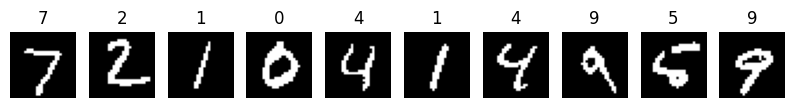

In [5]:
def MNIST_test():
    # Read the 10 first images from the MNIST dataset
    dataset = MNIST("./data/t10k-images-idx3-ubyte.gz", "./data/t10k-labels-idx1-ubyte.gz", 10)

    # Iterate the dataset
    images = []
    for img, label in dataset:
        images.append((img, label))

    # Show the result
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for i in range(len(images)):
        img = np.array(images[i][0]).reshape(28, 28)
        axes[i].set_title(f"{images[i][1]}")
        axes[i].imshow(img, cmap="gray")  # Redimensiona cada imagen a 28x28
        axes[i].axis("off")  # Oculta los ejes

    plt.show()

MNIST_test()

Load the train and test sets (it takes a while):

In [6]:
dataset_train       = MNIST("./data/train-images-idx3-ubyte.gz", "./data/train-labels-idx1-ubyte.gz")
dataset_test        = MNIST("./data/t10k-images-idx3-ubyte.gz", "./data/t10k-labels-idx1-ubyte.gz")
X_train, Y_train    = dataset_train.to_numpy()
X_test, Y_test      = dataset_test.to_numpy()

[MNIST]     image size: 28x28 total dataset images: 60000 images to be read: 60000
[MNIST]     image size: 28x28 total dataset images: 10000 images to be read: 10000


## RBM Base

For the implementation of the Restricted Boltzmann Machine (RBM), the sigmoid function has been defined as the activation function and is given by:


$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

Additionally, the KL-Divergence has been defined to perform experiments comparing distributions, and its formula is given by:

$$ D_{\text{KL}}(P \parallel Q) = \sum_{x} P(x) \log\frac{P(x)}{Q(x)} $$

In [7]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def kl_divergence(p, q):
    """
    The KL-Divergence measures how different are two probability distributions
    over the same variable. 
    """ 
    assert len(p) == len(q)
    q[q == 0] = 0.00000001 # Not let any element of q be 0
    return sum(p[i] * np.log2(p[i] / q[i]) for i in range(len(p)) if p[i] > 0)

In this implementation, an abstract class `RBM` is defined, serving as a template for the implementations of the Contrastive Divergence (CD) and Persistent Contrastive Divergence (PCD) algorithms.

#### Initialization

- **Bias Matrices**: The biases for the visible and hidden layers are created.
- **Weight Matrix**: The weight matrix `W` is defined to hold the weights connecting the layers of the RBM.
All parameters are initialized randomly using **Xavier Initialization** to ensure balanced weight scaling.


This is the description of the main methods implemented in this class. For more information about the algorithms behind, please reffer to the attached report.

1. **Model Persistence**:
   - `_load()`: Enables loading previously trained models.
   - `save()`: Allows saving the current model state.

2. **Abstract Method**:
   - `fit()`: Defined as an abstract method to be implemented by subclasses of `RBM`. This method is responsible for training the RBM.

3. **Implemented Methods**:
   - **Forward Propagation**:
     - Computes the activation probabilities of the hidden layer.
     - Samples the expected state of the hidden layer using a binomial distribution.
   - **Backward Propagation**:
     - Takes the state of the hidden layer to compute the activation probabilities of the visible layer.
     - Samples the expected state of the visible layer.

   - **Gibbs Sampling**:
      - A function that performs the forward and backward processes iteratively for \( k \) steps to sample the RBM.
   - **Reconstruct**
      - returns the reconstructed output of the RBM for a given input.
      
This abstract class serves as the foundation for specialized implementations of RBM training algorithms.

In [8]:
class RBM(ABC):
    """
        Implementation of Restricted Boltzman Machine for
        KISA Optimization Techniques by Sandra Burgos and
        Alan Garcia.
        
        References:
            - https://es.wikipedia.org/wiki/M%C3%A1quina_de_Boltzmann_restringida
            - https://upcommons.upc.edu/bitstream/handle/2117/344139/TFM.pdf?sequence=2&isAllowed=y
            - https://christian-igel.github.io/paper/TRBMAI.pdf
    """
    def __init__(self, visible_nodes, hidden_nodes, k: int = 1, pretrained: str = None) -> None:
        """
            n_v: number of visible nodes
            n_h: number of hidden nodes
            k -> Number of gibbsampling steps to be performed    
            pretrained: path of a rbm model checkpoint to load

            W -> Network weights
            a -> Visible layer biases
            b -> Hidden layer biases
        """
        
        if pretrained:
            self._load(pretrained)
        else:
            self.n_v = visible_nodes
            self.n_h = hidden_nodes
            self.k = k 
    
            # Initialize random weights from uniform distribution (Xavier initialization)
            limit = np.sqrt(6. / (self.n_v + self.n_h))
            self.W = np.random.uniform(low=-limit, high=limit, size=(self.n_v, self.n_h))
            self.a = np.random.uniform(low=-limit, high=limit, size=(self.n_v)) # np.zeros((1, visible_nodes))
            self.b = np.random.uniform(low=-limit, high=limit, size=(self.n_h)) # np.zeros((1, hidden_nodes))
    
    def _load(self, filename:str):
        """
            Load the params from a pretrained model 
        """
        f = open(filename, 'rb')
        tmp_dict = pickle.load(f)
        f.close()          

        self.__dict__.update(tmp_dict) 

    def save(self, filename:str):
        """
            Save the model params
        """
        base, ext = os.path.splitext(filename)  # Separate name and extension
    
        # Check if the file exists
        i = 1
        while os.path.exists(filename):
            filename = f"{base}_({i}){ext}"
            i += 1

        f = open(filename, 'wb')
        pickle.dump(self.__dict__, f, 2)
        f.close()

    def _forward(self, V):
        """ 
            Fordward propagation:
            Activation probability 
                > P(hj = 1 | v) = S (bj + sum_i=1^m(Wi,j * vi) )
                    where S is the sigmoid function, v the visible layers set and h the hidden layers set
                > P(h | v) = S( b + v @ W)
        """
        # V: (N, visible_nodes)
        h_p = np.dot(V, self.W) + self.b
        h_p = sigmoid(h_p)
        assert h_p.shape == (V.shape[0], self.n_h)

        h = np.random.binomial(1, h_p, size=h_p.shape)
        return h_p, h
    
    def _backward(self, H):
        """
            Backward:
            Activation probability > P(vi = 1 | h) = S (ai + sum_j=1^m(Wi,j * hj) )
                where S is the sigmoid function, v the visible layers set and h the hidden layers set
        """
        # V: (N, hidden_nodes)
        v_p = np.dot(H, self.W.T) + self.a
        v_p = sigmoid(v_p)
        assert v_p.shape == (H.shape[0], self.n_v)

        v = np.random.binomial(1, v_p, size=v_p.shape)
        return v_p, v

    def _gibbsampling(self, V):
        """
            Perform Gibbsampling
            OUTPUT: (h_p, h, v_p_, v_)
                h_p: hidden layer activation probs
                h: hidden layer samples
                v_p_: visible layer activation probs
                v_: visible layer reconstruction
        """
        v = V
        for i in range(self.k):
            h_p, h = self._forward(v)
            v_p, v = self._backward(h)
        return h_p, h, v_p, v

    @abstractmethod
    def fit():
        """
        The objective is to minimize the energy E of the system:
            E(v, h)=-a' v - b' h - v' W h
        So, to train the RBM we need to compute these terms:
            ∂Energy(v, h)/∂Wij = −hi · vj
            ∂Energy(v, h)/∂bj = −vj
            ∂Energy(v, h)/∂ci = −hi
        However, we don't have access to v and h but we have access
        to ther probabilities p_v and p_h, so we have to sample from
        P(v | h) and P(h | v)
        But direct sampling from those distributions is hard, thats why 
        CD, PCD and other methods were developed
        """
        raise NotImplemented

    def reconstruct(self, X):
        """
            Gibbsampling step to reconstruct output vk from v0 input.
            OUTPUT: generated visible layer output
        """
        h_p, h, v_p_, v_  = self._gibbsampling(X)
        return v_

To verify if the implementation of the methods is correct, a small test was conducted where an instance of `RBM_BASE` was created with the `fit()` method left unimplemented. A test input was defined as a column vector:

$$
v = \begin{bmatrix} 0.001 \\ 1 \\ 0.001 \\ 1 \end{bmatrix}
$$

This vector is passed through the `forward()` and `backward()` functions to ensure that the matrix operations are correct. Finally, the `reconstruct()` method is used to generate an output \( v' \).


In [9]:
# Example data input
v = np.array([
    [0.001, 1, 0.001, 1]
    ])

# Instantiate the RBM test object
class RBM_BASE(RBM):
    def __init__(self, visible_nodes, hidden_nodes):
        super().__init__(visible_nodes, hidden_nodes)
    def fit():
        # Train not implemented for just testing 
        # the vissible and hidden layers
        pass
rbm = RBM_BASE(4, 2)
p_h, h = rbm._forward(v)

print("RBM BASE TEST")
print(f"Test input shape: {v.shape} Test input: \n{v}")
print(f"rbm visible nodes: {rbm.n_v} hidden nodes: {rbm.n_v}")
print(f"rbm.a biasses shape: {rbm.a.shape} rbm.a biasses: \n{rbm.a}")
print(f"rbm.b biasses shape: {rbm.b.shape} rbm.b biasses: \n{rbm.b}")
print(f"rbm.W weights shape: {rbm.W.shape} rbm.W weights: \n{rbm.W}")
print(f"rbm forward shape{p_h.shape} rbm forward out: \n{p_h}")

p_v, v = rbm._backward(p_h)
print(f"rbm backward shape{p_v.shape} rbm backward out: \n{p_v}")

v_ = rbm.reconstruct(v)
print(f"rbm reconstruct process for v input and {rbm.k} gibbsampling steps: \n{v_}")
    
# The goal is to reduce the divergence between the input probability
# dsitribution and the output. 
# v = np.array([1, 0.001, 0.001, 1])
# v_ = np.array([1, 1, 1, 1])
# kld = 0.98860 >> 0 -> significant divergence
kld = kl_divergence(v.flatten() / np.sum(v.flatten()), v_.flatten() / np.sum(v_.flatten()))
print(f"KL-Divergence between input and final RBM probability output: {kld}")
print("===================================")
print()

RBM BASE TEST
Test input shape: (1, 4) Test input: 
[[0.001 1.    0.001 1.   ]]
rbm visible nodes: 4 hidden nodes: 4
rbm.a biasses shape: (4,) rbm.a biasses: 
[ 0.20223002  0.41614516 -0.95883101  0.9398197 ]
rbm.b biasses shape: (2,) rbm.b biasses: 
[ 0.66488528 -0.57532178]
rbm.W weights shape: (4, 2) rbm.W weights: 
[[-0.25091976  0.90142861]
 [ 0.46398788  0.19731697]
 [-0.68796272 -0.68801096]
 [-0.88383278  0.73235229]]
rbm forward shape(1, 2) rbm forward out: 
[[0.56072415 0.58772315]]
rbm backward shape(1, 4) rbm backward out: 
[[0.64366881 0.68832114 0.1481799  0.70571312]]
rbm reconstruct process for v input and 1 gibbsampling steps: 
[[1 1 0 0]]
KL-Divergence between input and final RBM probability output: 7.940179085645143



As can be observed, the reconstructed output deviates significantly from the input, indicating that the two distributions (input and output) differ considerably. The reconstructed output is:

$$
v' = \begin{bmatrix} 1 \\ 1 \\ 0 \\ 0 \end{bmatrix}
$$

and a KL-Divergence of 7.940.

## RBM Contrastive Divergence

Here is the implementation of the Contrastive Divergence algorithm for training Restricted Boltzmann Machines (RBMs). 

The `RBM_CD` class extends the previously implemented abstract `RBM` class, inheriting all its methods. However, in this class, the `fit()` method is implemented. 

**Overview of the `fit()` Method**

The `fit()` method defines the training loop for the RBM and returns a list of errors for each training epoch. For each epoch:

1. A list of batches is generated from the training dataset. 
2. During each iteration, the weights of the RBM are updated using the Contrastive Divergence algorithm. 

**Contrastive Divergence Implementation**

The Contrastive Divergence algorithm is implemented in the private method `_contrastive_divergence()`. This method carries out the positive and negative phases of the algorithm:

- **Positive Phase**: 
  - The input is taken.
  - The activation probabilities are calculated.

- **Negative Phase**: 
  - Gibbs sampling is performed.
  - The expected state of the visible layer is computed.

This training process refines the weights of the RBM to approximate the underlying data distribution effectively.

In [10]:
class RBM_CD(RBM):
    def __init__(self, visible_nodes, hidden_nodes, k: int = 1, pretrained: str = None) -> None:
       super().__init__(visible_nodes, hidden_nodes, k, pretrained)
    
    def _contrastive_divergence(self, batch, batch_size, lr):  
        """
            K-Step Contrastive Divergence Algorithm
        """      
        v = batch
        h_p, h, v_p_, v_ = self._gibbsampling(v)
        h_p_, h_ = self._forward(v_)
        
        # v_p_, v_, h_p_ and h_ are on the negative phase
        possitive_association = np.dot(v.T, h_p)
        negative_association = np.dot(v_.T, h_p_)
        
        
        # Update the parameters
        # W += lr * (possitive_associations - negative_associations)
        # possitive_associations = v • p_v
        # negative_associations = vk • p_vk
        self.W += lr * (possitive_association - negative_association) / batch_size
        self.a += lr * np.mean(v - v_, axis=0)
        self.b += lr * np.mean(h_p - h_p_, axis=0)
        
        #Compute loss for the instance
        error = np.sum((v - v_)**2) / batch_size
        return error
   
    def fit(self, X, epochs = 10, batch_dim = 32, lr = 0.01, verbose = False) -> list:
        """
             Train the RBM using Contrastive Divergence
        """
        train_errors = []
        for epoch in range(epochs):
            t_error = 0.0
            train_num = X.shape[0]
            batches = list(gen_batches(train_num, batch_dim))
            for batch in batches:
                batch = X[batch.start:batch.stop]
                batch_size = batch.shape[0]

                error = self._contrastive_divergence(batch, batch_size, lr)
                t_error += error
            
            t_error /= len(batches)
            train_errors.append(t_error)
            if verbose:
                print(f"epoch: {epoch}/{epochs} \t{'error:'} {t_error}")
        
        return train_errors

To verify that the implementation of the `fit()` method is correct, an instance `v` was defined and the method was executed. However, the result of the generation is quite random. While it shows some improvements compared to the untrained version, it is not a sufficiently significant sample to conclude that the model is not functioning correctly.

In [47]:
# Example data batch (size 1 instance)
v = np.array([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]])
epochs = 10
learning_rate = 0.01

# Instantiate the RBM
rbm = RBM_CD(v.shape[1], 10, k=1)
# Test
print("RBM CD TEST")
print(f"Test input shape: {v.shape} Test input: \n{v}")
print(f"Num epochs: {epochs}")
print(f"rbm visible nodes: {rbm.n_v} hidden nodes: {rbm.n_v}")
print(f"rbm k-step: {rbm.k} rbm learning rate: {learning_rate}")
print(f"Initial weights matrix ({rbm.W.shape}): \n{rbm.W}")

rbm.fit(v, epochs=epochs, batch_dim=1, lr=learning_rate, verbose=True)

print(f"Final weights matrix ({rbm.W.shape}): \n{rbm.W}")
v_ = rbm.reconstruct(v)
print(f"rbm reconstruct process for v after training with {rbm.k} gibbsampling steps: \n{v_}")

kld = kl_divergence(v.flatten() / np.sum(v.flatten()), v_.flatten() / np.sum(v_.flatten()))
print(f"KL-Divergence between input and final RBM probability output: {kld}")
print("===================================")

RBM CD TEST
Test input shape: (1, 10) Test input: 
[[0 1 0 1 0 1 0 1 0 1]]
Num epochs: 10
rbm visible nodes: 10 hidden nodes: 10
rbm k-step: 1 rbm learning rate: 0.01
Initial weights matrix ((10, 10)): 
[[ 0.41942984 -0.29829111  0.43369673 -0.17357193 -0.20889299  0.24839882
  -0.21394444 -0.48970077 -0.13844479  0.24260341]
 [-0.18955755  0.14192483  0.17540206  0.25604497  0.43503463 -0.07387189
  -0.36540535 -0.19835694 -0.07430705  0.23430637]
 [-0.53334799 -0.201797    0.30655219  0.18716524  0.25385842  0.34157158
   0.31026918  0.19957166 -0.06609748  0.52975543]
 [ 0.07566589 -0.32560002 -0.22696215  0.21203705  0.46527888 -0.35194447
  -0.45751649  0.41794632  0.45491423 -0.24496415]
 [-0.13442675  0.17547716 -0.18630233  0.41315666 -0.42987599 -0.50611512
  -0.31933736 -0.2343291  -0.42401767 -0.4757623 ]
 [ 0.28000422 -0.3677666   0.45342905 -0.14459913  0.1868893  -0.30080691
  -0.28446215  0.08183983  0.066431    0.29437812]
 [ 0.28242033  0.18697908 -0.05572467  0.427925

### XOR Function Modeling With CD RMB

Let's attempt to model an XOR logic gate using the Contrastive Divergence RBM that we have already implemented.

**Steps:**
1. **Training Set**: We will define the training set as all possible inputs and outputs of the XOR gate.
2. **Testing the Model**: After training, we will test the RBM by providing an impossible input for the XOR logic and observe if the reconstructed input follows the internal distribution of the XOR gate.

**Hypothesis:**
The hypothesis here is that since the Restricted Boltzmann Machine (RBM) has the ability to learn the distribution of a given dataset, when it is exposed to data that it hasn't seen before, it will try to adapt that input to its already learned distribution. This means the RBM should attempt to map the impossible input to the closest possible distribution that aligns with what it has learned from the XOR gate.

Here we define the train set and the model's hyperparameters:

In [58]:
# Train data
xor_logic = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
    [1, 1, 1],
])
# 
# Hyperparameters
k_gibbs_steps   = 1
learning_rate   = 0.0001
hidden_nodes    = 2     # Number of visible nodes are the input shape
epochs          = 10    # Number of epochs

In [59]:
# Instantiate the RBM object
rbm = RBM_CD(xor_logic.shape[1], hidden_nodes, k=k_gibbs_steps)

# Print some information about the matrix shapes
print("RBM CD FUNCTION APROXIMATION TEST")
print(f"XOR logic set shape: {xor_logic.shape}\t XOR logic:\n{xor_logic}")
print(f"rbm visible nodes: {rbm.n_v} hidden nodes: {rbm.n_v}")
print(f"rbm.a biasses shape: {rbm.a.shape} rbm.a biasses: \n{rbm.a}")
print(f"rbm.b biasses shape: {rbm.b.shape} rbm.b biasses: \n{rbm.b}")
print(f"rbm.W weights shape: {rbm.W.shape} rbm.W weights: \n{rbm.W}")

RBM CD FUNCTION APROXIMATION TEST
XOR logic set shape: (4, 3)	 XOR logic:
[[0 0 1]
 [0 1 0]
 [1 0 0]
 [1 1 1]]
rbm visible nodes: 3 hidden nodes: 3
rbm.a biasses shape: (3,) rbm.a biasses: 
[-0.28211012  0.04873252 -0.97860321]
rbm.b biasses shape: (2,) rbm.b biasses: 
[0.47075748 0.094851  ]
rbm.W weights shape: (3, 2) rbm.W weights: 
[[ 0.6399717   0.51983183]
 [ 0.88071179 -0.57750999]
 [-0.09575092 -0.69125243]]


In [60]:
rbm.fit(xor_logic, epochs=epochs, batch_dim=1, lr=learning_rate)

print(f"Final rbm.a biasses: \n{rbm.a}")
print(f"Final rbm.b biasses: \n{rbm.b}")
print(f"Final rbm.W weights: \n{rbm.W}")

Final rbm.a biasses: 
[-0.28241012  0.04843252 -0.97740321]
Final rbm.b biasses: 
[0.47065695 0.09464711]
Final rbm.W weights: 
[[ 0.63970223  0.51957884]
 [ 0.88044531 -0.57773615]
 [-0.09491578 -0.69081227]]


Here `v` is an impossible state of a XOR logic gate were `x1 = x2 = 1` and the output is `y = 0` where it should be `y = 1`

In [61]:
# Recontruction
v = np.array([[1, 1, 0]]) # This is not possible for XOR function
v_ = rbm.reconstruct(v)
print(f"Impossible inut: {v}") 
print(f"Reconstructed output: {v_}")

Impossible inut: [[1 1 0]]
Reconstructed output: [[0 1 1]]


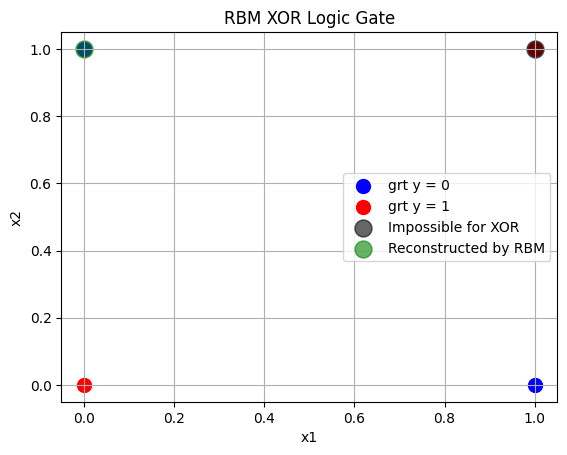

In [62]:
# Plot the results with matplotlib
grt_color_map = { 0: "blue", 1: "red" } # Ground_truth color map
rbm_color_map = { 0: "blue", 1: "red" } # RBM prediction color map

# Ground truth
grt_xor_0 = xor_logic[xor_logic[:, 2] == 0]
grt_xor_1 = xor_logic[xor_logic[:, 2] == 1]
plt.scatter(grt_xor_0[:, 0], grt_xor_0[:, 1], s = 100, color = grt_color_map[0], label = "grt y = 0", )
plt.scatter(grt_xor_1[:, 0], grt_xor_1[:, 1], s = 100, color = grt_color_map[1], label = "grt y = 1", )
    
# Reconstruction    
plt.scatter(v[:, 0], v[:, 1], s = 150, color = "black", label = "Impossible for XOR", alpha=0.6)
plt.scatter(v_[:, 0], v_[:, 1], s = 150, color = "green", label = "Reconstructed by RBM", alpha=0.6)

# Show
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("RBM XOR Logic Gate")
plt.grid()
plt.legend()
plt.show()

As we can observe, when an impossible input is given to the RBM trained to follow an XOR distribution, it generates an output similar to the input but one that does follow the XOR distribution.

### MNIST Data Reconstruction With CD RBM

In this example, we will train the Contrastive Divergence RBM using images from the MNIST dataset. After training, we will compare the images from the training set with their corresponding reconstructions generated by the RBM.

The goal is to observe how well the RBM can reconstruct handwritten digits from the MNIST dataset and evaluate its ability to learn the underlying distribution of these images.

In [25]:
# Hyperparameters
k = 1
batch_size    = 64
learning_rate = 0.1
hidden_nodes  = 30      # Number of visible nodes are the input shape
epochs        = 100     # Number of epochs

print("RBM CD MNIST RECONSTRUCTION TEST")
print(f"Hyperparameters:")
print(f"\tX_train instances: {X_train.shape[0]}\tX_test instances: {X_test.shape[0]}")
print(f"\tbatch size: {batch_size}\tepochs: {epochs}\tlearning rate: {learning_rate}")
print(f"\tvisible nodes: {X_train.shape[1]}\thidden nodes:{hidden_nodes}")

RBM CD MNIST RECONSTRUCTION TEST
Hyperparameters:
	X_train instances: 60000	X_test instances: 10000
	batch size: 64	epochs: 100	learning rate: 0.1
	visible nodes: 784	hidden nodes:30


In [ ]:
# Initialize RBM with 30 hidden units and train it for 100 epochs
rbm = RBM_CD(visible_nodes=X_train.shape[1], hidden_nodes=hidden_nodes, k=k)
# # Load a pretrained model
# model_path = "./models/RBM_CD_e100_bt64_lr0.1_hn30_k1.pt"
# rbm = RBM_CD(None, None, pretrained= model_path)

print("Train:")
train_loss = rbm.fit(X_train, epochs=epochs, batch_dim=batch_size, lr=learning_rate, verbose=True)
# rbm.save(f"./models/RBM_CD_e{epochs}_bt{batch_size}_lr{learning_rate}_hn{hidden_nodes}_k{k}.pt")

Train:
epoch: 0/100 	error: 102.56411580490405
epoch: 1/100 	error: 82.11342284115139
epoch: 2/100 	error: 78.00286513859275
epoch: 3/100 	error: 76.05032316098081
epoch: 4/100 	error: 75.02903451492537
epoch: 5/100 	error: 74.35902518656717
epoch: 6/100 	error: 73.99050506396588
epoch: 7/100 	error: 73.63584421641791
epoch: 8/100 	error: 73.45230876865672
epoch: 9/100 	error: 73.22809501599147
epoch: 10/100 	error: 73.02608608742004
epoch: 11/100 	error: 72.9786447228145
epoch: 12/100 	error: 72.8045875533049
epoch: 13/100 	error: 72.77325426439232
epoch: 14/100 	error: 72.7452025586354
epoch: 15/100 	error: 72.64547241471216
epoch: 16/100 	error: 72.58002398720683
epoch: 17/100 	error: 72.43611740405117
epoch: 18/100 	error: 72.32211154051173
epoch: 19/100 	error: 72.25921175373135
epoch: 20/100 	error: 72.09143456823028
epoch: 21/100 	error: 71.98898920575692
epoch: 22/100 	error: 71.8256263326226
epoch: 23/100 	error: 71.7155183901919
epoch: 24/100 	error: 71.64120802238806
epoch: 

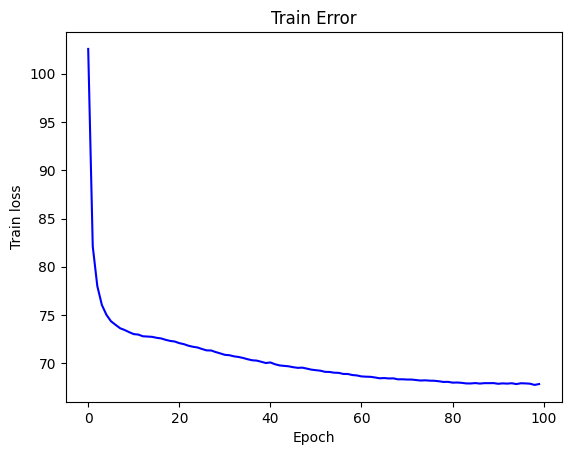

In [ ]:
plt.plot(range(len(train_loss)), train_loss, color = "blue", label = "train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CD RBM Train Error")
plt.legend()
plt.show()

Perform the RBM reconstruction over a restricted set from the `test_set` where there is one example of each label and then show the results

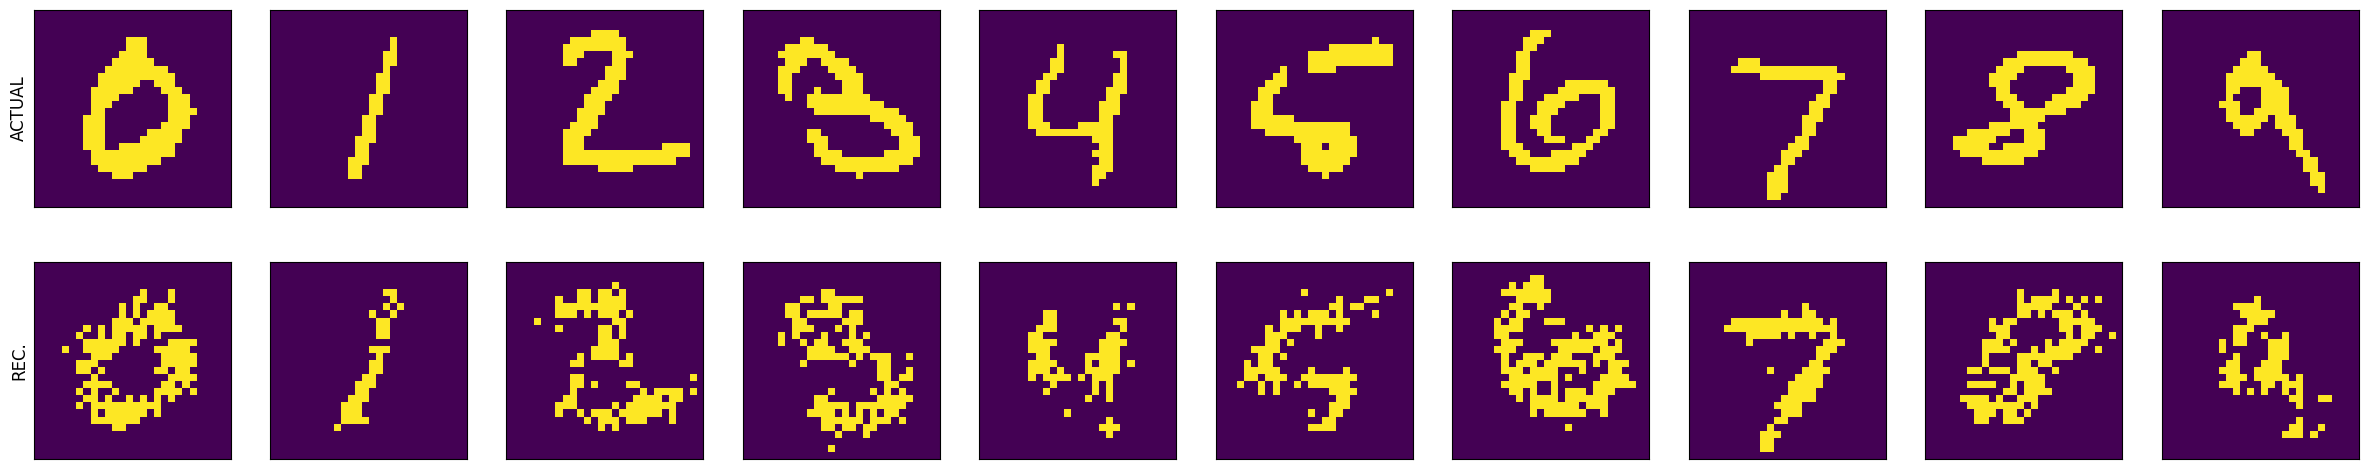

In [21]:
# reconstruction
digit_indices = [np.where(Y_test == i)[0][0] for i in range(10)]
resticted_set = X_test[digit_indices]

reconstructed = rbm.reconstruct(resticted_set)

# show 10 sample images
rows = 2
columns = 10

fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 6))
for i in range(rows):
    for j in range(columns):
        if i==0:
          axes[i, j].imshow(resticted_set[j].reshape(28, 28))
        else:
          axes[i, j].imshow(reconstructed[j].reshape(28, 28))

        axes[i, j].tick_params(left = False, right = False , labelleft = False,
                labelbottom = False, bottom = False)

axes[0, 0].set_ylabel("ACTUAL", fontsize=12)
axes[1, 0].set_ylabel("REC.", fontsize=12)
plt.show()

It is also iteresting to show the evolution of the loss on the train set and the evaluation error on the test set. For this reason we have implemented the train and eval loops for each epoch as shown here: 

In [41]:
# It takes a little bit to run. 
# We have set the number of epochs of this experiment to 10 as it
# is just to see the evolution, not a full training
def show_trloss_evloss(X_train, X_test, epochs, batch_dim, lr):
    test_rbm = RBM_CD(visible_nodes=X_train.shape[1], hidden_nodes=hidden_nodes, k=k)
    train_errors = []
    eval_errors = []

    for _ in range(epochs):
        def train_loop(X, batch_dim, lr):
            train_num = X.shape[0]
            batches = list(gen_batches(train_num, batch_dim))
            t_error = 0.0
            for batch in batches:
                batch = X[batch.start:batch.stop]
                batch_size = batch.shape[0]
                error = test_rbm._contrastive_divergence(batch, batch_size, lr)
                t_error += error
        
            return t_error / len(batches)
        def test_loop(X):
            x_ = test_rbm.reconstruct(X)
            return np.sum((X - x_)**2) / X.shape[0]

        train_errors.append(train_loop(X_train, batch_dim, lr))
        eval_errors.append(test_loop(X_test))

    return train_errors, eval_errors

train_loss, test_loss = show_trloss_evloss(X_train, X_test, 10, 64, 0.1)

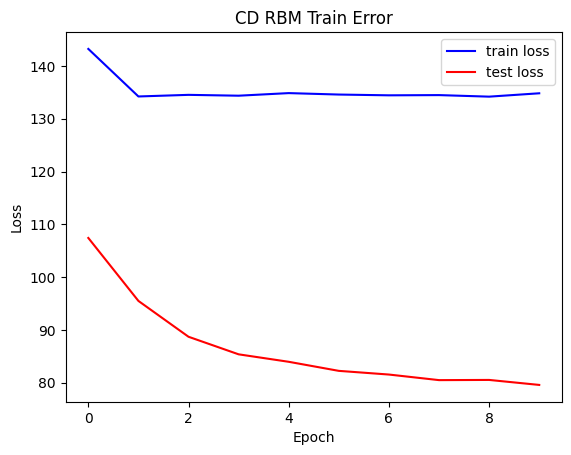

In [44]:
plt.plot(range(len(train_loss)), train_loss, color = "blue", label = "train loss")
plt.plot(range(len(test_loss)), test_loss, color = "red", label = "test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CD RBM Train Error")
plt.legend()
plt.show()

### MNIST Number Generator With CD RBM

The main idea is to train an RBM with image data and the encoded labels, and then, given just the label, generate the corresponding number. This approach is similar to the XOR application described earlier, but instead of providing an impossible input, we provide the label of the number image we want to generate.

To achieve this, a new class `MNIST_RBM_CD` is defined, which extends the `RBM_CD` class. The `fit()` method is overloaded in this class with the following objectives:

1. **Data Preparation**: The training data and their corresponding labels are encoded using one-hot encoding.
2. **Training**: The RBM is trained with the encoded image-label pairs.

Additionally, a new function `generate_MNIST_image()` has been implemented. This function takes a number between 0 and 9 as input and attempts to generate the corresponding image based on the trained RBM.

The goal is to explore how well the RBM can generate MNIST-like images when provided with a label, showcasing the model's ability to learn both image data and label relationships.

In [ ]:
class MNIST_RBM_CD(RBM_CD):
    num_labels = 10
    def __init__(self, visible_nodes, hidden_nodes, k: int = 1, pretrained: str = None) -> None:
        super().__init__(visible_nodes + self.num_labels, hidden_nodes, k, pretrained)

    def fit(self, X, Y, epochs=10, batch_dim=32, lr=0.01, verbose=False) -> list:
        """
            Train a RBM using the Contrastive Divergence algorithm for generating MNIST
            images with a given label.

            X: image data (N, d) where d is 32x32
            Y: label data (N, 1) it goes [0, 9]

            The key is to encode the Y labels as binary and add to each instance of X
        """

        # One-Hot encoding for the Y labels
        encoded = np.zeros((Y.size, self.num_labels))
        encoded[np.arange(Y.size), Y] = 1
        
        # Add the encoded matrix to the image data matrix
        X = np.concatenate((X, encoded), axis=1)

        # Train the RBM and return the train loss
        return super().fit(X, epochs, batch_dim, lr, verbose)
    
    def generate_MNIST_image(self, number: int):
        """
            One-hot encoding for the number and
            0s for the image data input.

            The expected output is the generated image 
        """
        assert number >= 0 and number <= 9
        
        # Create random binary image with prob 0.5 
        #X = np.random.binomial(1, 0.5, size=(1, self.n_v - self.num_labels))
        X = np.zeros((1, self.n_v - self.num_labels))
        encoded = np.zeros((1, self.num_labels))
        encoded[0, number] = 1
        X = np.concatenate((X, encoded), axis=1)

        # Reconstruct the image
        # aux = self.k
        # self.k = 1 # let it "dream"
        x_ = self.reconstruct(X)
        # self.k = aux

        # Remove the label
        return x_[:, :-self.num_labels]


In [144]:
# Hyperparameters
batch_size    = 64
learning_rate = 0.1
hidden_nodes  = 50      # Number of visible nodes are the input shape
epochs        = 100     # Number of epochs

In [192]:
# # Initialize RBM with 30 hidden units and train it for 100 epochs
# rbm = MNIST_RBM_CD(visible_nodes=X_train.shape[1], hidden_nodes=hidden_nodes, k=k)
#  
# print("Train:")
# train_loss = rbm.fit(X_train, Y_train, epochs=epochs, batch_dim=batch_size, lr=learning_rate, verbose=True)
# rbm.save(f"./models/MNIST_RBM_CD_e{epochs}_bt{batch_size}_lr{learning_rate}_hn{hidden_nodes}_k{k}.pt")

# Load a pretrained model
model_path = "./models/MNIST_RBM_CD_e100_bt64_lr0.1_hn30_k1.pt"
rbm = MNIST_RBM_CD(X_train.shape[1], hidden_nodes, pretrained= model_path)

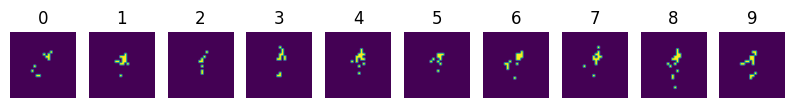

In [193]:
# Show the result
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):

    img = rbm.generate_MNIST_image(i)
    img = img.reshape(28, 28) # Resize each image to 28x28

    axes[i].set_title(f"{i}")
    axes[i].imshow(img)  
    axes[i].axis("off")

plt.show()

It probably doesn't work as expected because the presence of the label is just one pixel. It may work by making more important the weights of the labels (more nodes per label). However, the learned model is able to infer the label of each image at some point: 

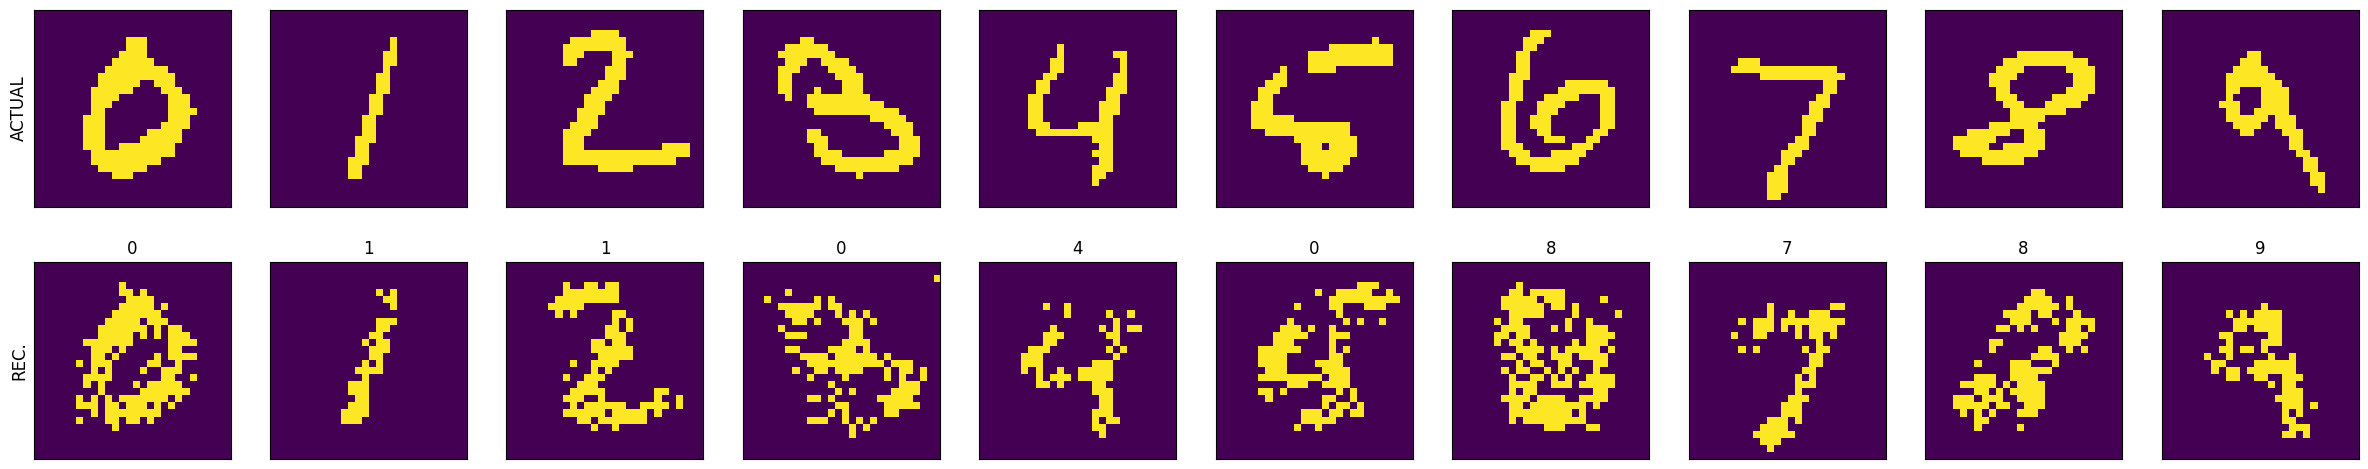

In [194]:
# reconstruction
digit_indices = [np.where(Y_test == i)[0][0] for i in range(10)]
resticted_set = X_test[digit_indices]
reconstructed = rbm.reconstruct( np.concatenate((resticted_set, np.zeros((resticted_set.shape[0], 10))), axis=1))

# show 10 sample images
rows = 2
columns = 10

fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 6))
for i in range(rows):
    for j in range(columns):
        if i==0:
          axes[i, j].imshow(resticted_set[j].reshape(28, 28))
        else:
          axes[i, j].imshow(reconstructed[j, :-10].reshape(28, 28))
          label = np.argmax(reconstructed[j, -10:])
          axes[i, j].set_title(label)
        axes[i, j].tick_params(left = False, right = False , labelleft = False,
                labelbottom = False, bottom = False)

axes[0, 0].set_ylabel("ACTUAL", fontsize=12)
axes[1, 0].set_ylabel("REC.", fontsize=12)
plt.show()

## RBM Persistent Contrastive Divergence

Here is the implementation of the PCD algorithm. We implemented the RBM_PCD class as a subclass of RBM. We added the `visible_persistent` attribute to it, which will be key for the algorithm.  This allows the chain to better explore the model's probability space, reaching a closer approximation to its stationary distribution.

In [ ]:
class RBM_PCD(RBM):
    def __init__(self, visible_nodes, hidden_nodes, batch_size = 32, k: int = 2, pretrained: str = None) -> None:
        super().__init__(visible_nodes, hidden_nodes, k, pretrained)
        self.current_step = 0 # For learning rate decay

        # Initialize the visible persistent values
        self.visible_persistent = np.random.binomial(1, 0.5, size=(batch_size, self.n_v))  
    
    def _persistent_contrastive_divergence(self, batch, batch_size, lr, weight_decay):
        """
            K-Step Parallel Tempering Algorithm
        """
        
        v = batch
        v_persistent = self.visible_persistent

        h_p, _= self._forward(v)
        _, _, _, v_persistent_ = self._gibbsampling(v_persistent)
        h_p_persistent_, _ = self._forward(v_persistent_)

        possitive_association = np.dot(v.T, h_p)
        negative_association = np.dot(v_persistent_.T, h_p_persistent_)
        
        # Update the parameters
        self.W += lr * (possitive_association - negative_association) / batch_size  - weight_decay * self.W / batch_size
        self.a += lr * np.mean(v - v_persistent_, axis=0)
        self.b += lr * np.mean(h_p - h_p_persistent_, axis=0)
        self.visible_persistent = v_persistent_

        #Compute loss for the instance
        error = np.sum((v - self.visible_persistent)**2) / batch_size
        return error

    def fit(self, X, epochs = 10, batch_dim = 32, lr = 0.1, weight_decay = 0.001, verbose = False) -> list:
        """
            Train the RBM using Persistent Contrastive Divergence
        """
        self.current_step = 0 # lr linear decay

        train_errors = []
        for epoch in range(epochs):
            t_error = 0.0
            train_num = X.shape[0]
            batches = list(gen_batches(train_num, batch_dim))
            for batch in batches:
                batch = X[batch.start:batch.stop]
                batch_size = batch.shape[0]
                
                if batch_size != batch_dim:
                    continue # skip

                # Linear learning rate decay
                learning_rate = lr
                # learning_rate = lr *(1 - self.current_step / (batch_size * len(batches) * epochs))
                # self.current_step += 1

                t_error += self._persistent_contrastive_divergence(batch, batch_size, learning_rate, weight_decay)
           
            t_error /= len(batches)
            train_errors.append(t_error)
            
            if verbose:
                print(f"epoch: {epoch}/{epochs} \t{'error:'} {t_error}")
        return train_errors

### MNIST Data Reconstruction With PCD RBM

We reconstruct the dataset with the PCD algorithm. We train the model with 30 hidden nodes, and 100 epochs and see the error it generates on the training set for each epochs.  

We also test the model on the testing dataset, in order to make a comparison with the training error. 

In [35]:
# Hyperparameters
k = 1
batch_size    = 64
learning_rate = 0.1
hidden_nodes  = 30      # Number of visible nodes are the input shape
epochs        = 100     # Number of epochs

print("RBM PCD MNIST RECONSTRUCTION TEST")
print(f"Hyperparameters:")
print(f"\tX_train instances: {X_train.shape[0]}\tX_test instances: {X_test.shape[0]}")
print(f"\tbatch size: {batch_size}\tepochs: {epochs}\tlearning rate: {learning_rate}")
print(f"\tvisible nodes: {X_train.shape[1]}\thidden nodes:{hidden_nodes}")

RBM PCD MNIST RECONSTRUCTION TEST
Hyperparameters:
	X_train instances: 60000	X_test instances: 10000
	batch size: 64	epochs: 100	learning rate: 0.1
	visible nodes: 784	hidden nodes:30


In [36]:
# Initialize RBM with 30 hidden units and train it for 100 epochs
rbm = RBM_PCD(visible_nodes=X_train.shape[1], hidden_nodes=hidden_nodes, batch_size=batch_size, k= k)

print(f"Training:")
train_loss = rbm.fit(X_train, epochs=epochs, batch_dim=batch_size, lr=learning_rate, verbose=True)
# rbm.save(f"./models/RBM_PCD_e{epochs}_bt{batch_size}_lr{learning_rate}_hn{hidden_nodes}_k{k}.pt")

Training:
epoch: 0/100 	error: 143.21929970682302
epoch: 1/100 	error: 134.15205223880596
epoch: 2/100 	error: 134.5965651652452
epoch: 3/100 	error: 134.67064232409382
epoch: 4/100 	error: 134.67047574626866
epoch: 5/100 	error: 134.77858475479744
epoch: 6/100 	error: 134.32037913113007
epoch: 7/100 	error: 134.3699027185501
epoch: 8/100 	error: 134.3660381130064
epoch: 9/100 	error: 134.35402785181236
epoch: 10/100 	error: 134.47496335287846
epoch: 11/100 	error: 134.55991804371
epoch: 12/100 	error: 134.28193296908316
epoch: 13/100 	error: 134.43340218550105
epoch: 14/100 	error: 134.33835287846483
epoch: 15/100 	error: 134.63736007462686
epoch: 16/100 	error: 134.57042910447763
epoch: 17/100 	error: 134.58863606076758
epoch: 18/100 	error: 134.3891591151386
epoch: 19/100 	error: 134.90671641791045
epoch: 20/100 	error: 134.46423574093816
epoch: 21/100 	error: 134.35494402985074
epoch: 22/100 	error: 134.87180170575692
epoch: 23/100 	error: 134.95950493070362
epoch: 24/100 	error: 1

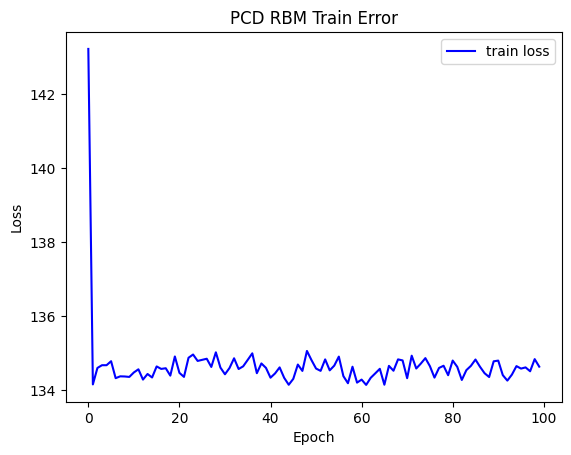

In [37]:
plt.plot(range(len(train_loss)), train_loss, color = "blue", label = "train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PCD RBM Train Error")
plt.legend()
plt.show()

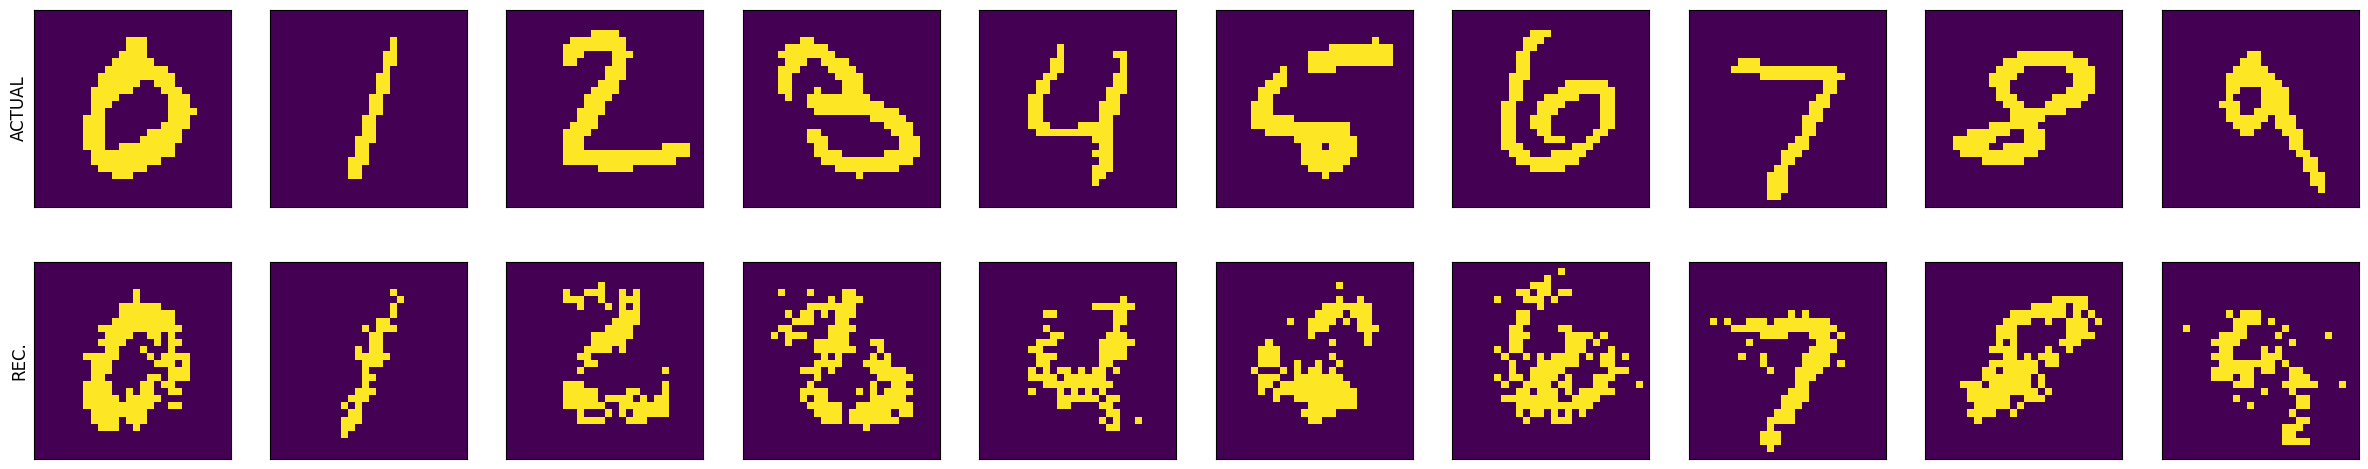

In [38]:
# reconstruction
digit_indices = [np.where(Y_test == i)[0][0] for i in range(10)]
resticted_set = X_test[digit_indices]

reconstructed = rbm.reconstruct(resticted_set)

# show 10 sample images
rows = 2
columns = 10

fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 6))
for i in range(rows):
    for j in range(columns):
        if i==0:
          axes[i, j].imshow(resticted_set[j].reshape(28, 28))
        else:
          axes[i, j].imshow(reconstructed[j].reshape(28, 28))

        axes[i, j].tick_params(left = False, right = False , labelleft = False,
                labelbottom = False, bottom = False)

axes[0, 0].set_ylabel("ACTUAL", fontsize=12)
axes[1, 0].set_ylabel("REC.", fontsize=12)
plt.show()

The same experiment as before reimplementing the train and test loops to see the mean squared error evolution difference for each epoch.

In [42]:
def show_trloss_evloss(X_train, X_test, epochs, batch_dim, lr):
    test_rbm = RBM_PCD(visible_nodes=X_train.shape[1], hidden_nodes=hidden_nodes, batch_size=batch_dim, k= k)
    train_errors = []
    eval_errors = []

    for _ in range(epochs):
        def train_loop(X, batch_dim, lr):
            train_num = X.shape[0]
            batches = list(gen_batches(train_num, batch_dim))
            t_error = 0.0
            for batch in batches:
                batch = X[batch.start:batch.stop]
                batch_size = batch.shape[0]
                if batch_size != batch_dim:
                    continue # skip
                error = test_rbm._persistent_contrastive_divergence(batch, batch_size, lr, weight_decay=0.001)
                t_error += error
        
            return t_error / len(batches)
        def test_loop(X):
            x_ = test_rbm.reconstruct(X)
            return np.sum((X - x_)**2) / X.shape[0]

        train_errors.append(train_loop(X_train, batch_dim, lr))
        eval_errors.append(test_loop(X_test))

    return train_errors, eval_errors

train_loss, test_loss = show_trloss_evloss(X_train, X_test, 10, 64, 0.1)

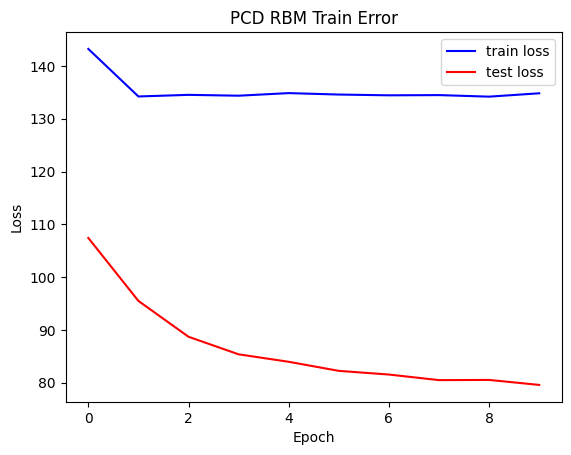

In [45]:
plt.plot(range(len(train_loss)), train_loss, color = "blue", label = "train loss")
plt.plot(range(len(test_loss)), test_loss, color = "red", label = "test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PCD RBM Train Error")
plt.legend()
plt.show()